# Data Stream Processing - Project 3 : EXstream

In [1]:
# Import librairies.
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby


## The data

In [2]:
# Get files
DATAPATH =  "../data/custom_no_streaming_8/folder_1"
files = glob.glob(rf"{DATAPATH}/*")
files

['../data/custom_no_streaming_8/folder_1\\1_1.csv',
 '../data/custom_no_streaming_8/folder_1\\1_2.csv',
 '../data/custom_no_streaming_8/folder_1\\2_1.csv',
 '../data/custom_no_streaming_8/folder_1\\2_2.csv',
 '../data/custom_no_streaming_8/folder_1\\3_1.csv',
 '../data/custom_no_streaming_8/folder_1\\3_2.csv',
 '../data/custom_no_streaming_8/folder_1\\labels.csv']

In [3]:
# Read anomaly files and concatenate dataframes
dfs = []
for file in files[:-1]:
    df = pd.read_csv(file)
    # Extract the filename without the parent folder path and extension
    filename = file.split('\\')[-1].split('.')[0]
    # Add a new column "anomaly_type" with the extracted filename
    df.insert(1, column="trace_id", value=filename)
    df.rename({"Unnamed: 0": "time"}, axis=1, inplace=True)
    dfs.append(df)

# Concatenate all dataframes except labels.csv
anomaly_df = pd.concat(dfs)

# Create a separate dataframe for labels.csv
labels_df = pd.read_csv(files[-1], index_col=0)

# Print the resulting dataframes
print("Concatenated DataFrame (except labels.csv):")
print(anomaly_df.shape)

print("\nLabels DataFrame:")
print(labels_df.shape)

Concatenated DataFrame (except labels.csv):
(272935, 10)

Labels DataFrame:
(29, 7)


In [4]:
# Rename values in the "anomaly_type" column based on the specified mapping
mapping = {
    "1_1": "bursty_input",
    "1_2": "bursty_input",
    "2_1": "stalled_input",
    "2_2": "stalled_input",
    "3_1": "cpu_contention",
    "3_2": "cpu_contention"
}
anomaly_df.insert(2, column="anomaly_type", value=anomaly_df['trace_id'].replace(mapping))


In [5]:
# Missing values.
anomaly_df.isna().sum()

time                                                   0
trace_id                                               0
anomaly_type                                           0
driver_BlockManager_memory_memUsed_MB_value            0
driver_jvm_heap_used_value                             0
avg_jvm_heap_used_value                                0
avg_executor_filesystem_hdfs_write_ops_value_1_diff    0
avg_executor_cpuTime_count_1_diff                      0
avg_executor_runTime_count_1_diff                      0
avg_executor_shuffleRecordsRead_count_1_diff           0
avg_executor_shuffleRecordsWritten_count_1_diff        0
dtype: int64

In [6]:
bursty_input1_df = anomaly_df[anomaly_df["trace_id"] == "1_1"]

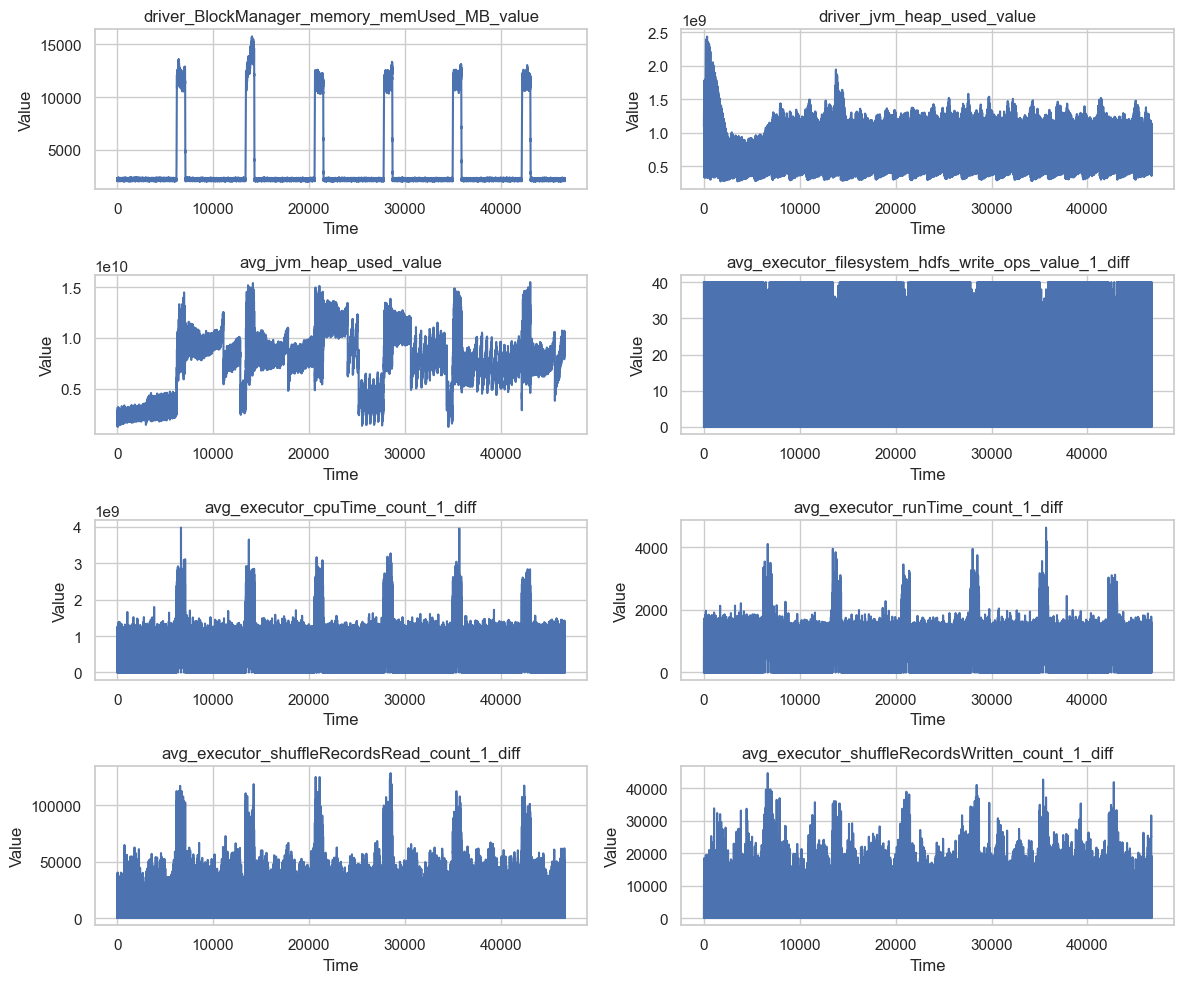

In [7]:
# Extract columns excluding the first three
columns_to_plot = bursty_input1_df.columns[3:]

# Set up the subplot grid
num_rows = 4
num_cols = 2

# Create a new figure with seaborn style
plt.figure(figsize=(12, 10))
sns.set(style="whitegrid")

# Plot each column in the grid
for i, column in enumerate(columns_to_plot, 1):  # Start index at 1 for better subplot titles
    plt.subplot(num_rows, num_cols, i)
    sns.lineplot(x='time', y=column, data=bursty_input1_df)
    plt.title(column)
    plt.xlabel('Time')
    plt.ylabel('Value')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Sufficient features space

Input
- Abnormal interval: $I_A$.
- Reference interval $I_R$.

Ouput
- [ ] List of all the features occuring either during $I_A$ or $I_R$. 
  - [ ] Filter the data according to the time two intervals.
  - [ ] Remove features that do not vary during this intervals / Select all the features varying during this time interval.

In [8]:
# TODO : à optimiser sans boucle for

In [9]:
#---CODE HERE----


# Function to annotate periods
def annotate_period(row, labels_df):
    for i, label_row in labels_df.iterrows():
        if row['trace_id'] == label_row['trace_id']:
            if label_row['ref_start'] <= row['time'] < label_row['ref_end']:
                return 'I_R'
            if label_row['ano_start'] <= row['time'] < label_row['ano_end']:
                return 'I_A'
    return "not_a_period"

# Apply the function to annotate periods
bursty_input1_df['period_type'] = bursty_input1_df.apply(lambda row: annotate_period(row, labels_df), axis=1)


bursty_input1_df_filter = bursty_input1_df[bursty_input1_df["period_type"] != "not_a_period"]
#bursty_input1_df[bursty_input1_df["period_type"] == "I_R"].to_csv("bursty_input1_ref.csv", sep = ";")

continuous_features = [
    'driver_BlockManager_memory_memUsed_MB_value',
    'driver_jvm_heap_used_value',
    'avg_jvm_heap_used_value',
    'avg_executor_filesystem_hdfs_write_ops_value_1_diff',
    'avg_executor_cpuTime_count_1_diff',
    'avg_executor_runTime_count_1_diff',
    'avg_executor_shuffleRecordsRead_count_1_diff',
    'avg_executor_shuffleRecordsWritten_count_1_diff'
]

# give a number to each feature
continuous_features_int = [i for i in range(len(continuous_features))]

# Calculate variance for the specified continuous features
continuous_variances = bursty_input1_df_filter[continuous_features].var()

# Select continuous features with variance above a threshold (e.g., 0)
selected_continuous_features = continuous_variances[continuous_variances > 0].index.tolist()

# Since we are only dealing with continuous variables here,
bursty_input1_df_final = bursty_input1_df_filter[selected_continuous_features + ["time"]]



C:\Users\choho\AppData\Local\Temp\ipykernel_13752\1800152696.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bursty_input1_df['period_type'] = bursty_input1_df.apply(lambda row: annotate_period(row, labels_df), axis=1)


def annotate_anomaly(row, labels_df):
    for i, label_row in labels_df.iterrows():
        if row['trace_id'] == label_row['trace_id']:
            if label_row['ref_start'] <= row['time'] < label_row['ref_end']:
                return row['ano_id']
            if label_row['ano_start'] <= row['time'] < label_row['ano_end']:
                return row['ano_id']
    return "not_an_anomaly_ref_or_ano"
#bursty_input1_df['ano_id'] = bursty_input1_df.apply(lambda row: annotate_anomaly(row, labels_df), axis=1)


## Single feature reward (section 4)

Workflow:
* [x] Class Entropy
* [x] Segmentation Entropy
* [x] Penalization (for mixed segments)
* [x] Normalization by feature size

### Class entropy

**Input**
* $TS_A$, $TS_R$ two time series from the abnormal and the reference intervals respectively.

**Compute**

* $|TS_A|$, $|TS_A|$: number of points in the two series.
* The weight of each series (empirical probability that one point belong to that class).
$$
    p_A = \frac{|TS_A|}{|TS_A| + |TS_R|}, \quad p_R = \frac{|TS_R|}{|TS_A| + |TS_R|}
$$
* The class entropy of the feature $f$:
$$
    H_{Class}(f) = p_A \cdot \log\left(\frac{1}{p_A}\right) + p_R \cdot \log\left(\frac{1}{p_R}\right)
$$

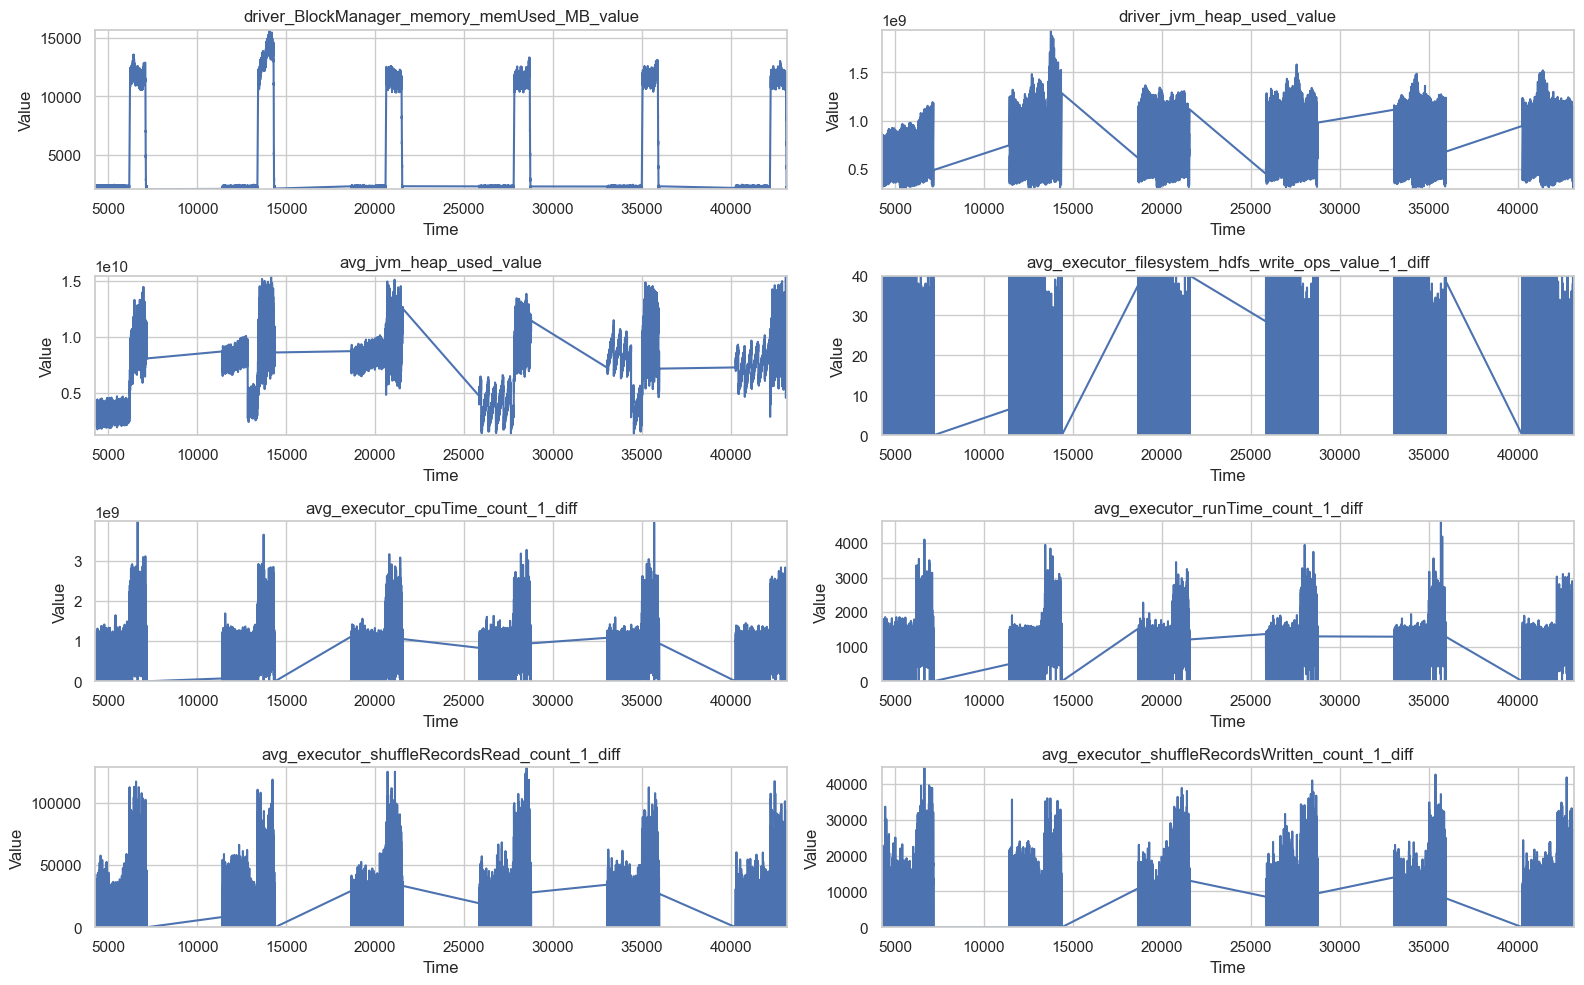

In [10]:
#---CODE HERE----

# Set up the subplot grid
num_rows = len(continuous_features) // 2 + 1
num_cols = 2

# figure with seaborn style
plt.figure(figsize=(16, 12))  # Adjusted figure size for better visibility
sns.set(style="whitegrid")

# Plot each column in the grid
for i, column in enumerate(selected_continuous_features, 1):  # Start index at 1 for better subplot titles
    ax = plt.subplot(num_rows, num_cols, i)
    sns.lineplot(x='time', y=column, data=bursty_input1_df_final, ax=ax)
    plt.title(column)
    plt.xlabel('Time')
    plt.ylabel('Value')
    
    # limits based on each column's data for better scale representation
    plt.ylim(bursty_input1_df_final[column].min(), bursty_input1_df_final[column].max())
    plt.xlim(bursty_input1_df_final['time'].min(), bursty_input1_df_final['time'].max())

plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()  # Display the plot


In [11]:
TSR = bursty_input1_df_filter[bursty_input1_df_filter["period_type"] == "I_R"]
TSA = bursty_input1_df_filter[bursty_input1_df_filter["period_type"] == "I_A"]

def class_entropy(TSA, TSR):
    p_A = len(TSA) / (len(TSA) + len(TSR))
    p_R = len(TSR) / (len(TSA) + len(TSR))

    H_Class_f = p_A * np.log(1/p_A) + p_R * np.log(1/p_R)
    return H_Class_f

class_entropy(TSA, TSR)

0.6365141682948128

### Segmentation entropy (???)

**Input**
* Time series $TS$ of a feature $f$: $(X_t)_{t=1,\dots,T}$. 
* Anomaly time annotations: $A_S = (a_s)_{s=1,\dots, S}  \subset \{1, \dots, T\}$  

Example: In the sequence, AANNNNANNN. The anomaly time anotations would be (1,2,7). We are given only the different time intervals from which we have to derive the different anomaly time anotation and then the segment (this is just an heuristic, not necessarily the way it would be implemented).

**Compute**
* The segments. A segment is a (contiguous) sequence of point with the same label (anomaly or not anomaly)
* The segmentation entropy of the feature $f$:
$$
    H_{Segmentation}(f) = \sum_{i=1}^{n} p_i \cdot \log\left(\frac{1}{p_i}\right)
$$

### Penalization for mixed segments

$$
    H^+_{Segmentation}(f) = H_{Segmentation}(f) + \sum_{j=1}^{m} H_{Segmentation}(c_j^*)
$$

In [12]:
#---CODE HERE----
def generate_TS(bursty_input1_df_filter, variable):
    # new DataFrame to store the unique values and their associated period_type
    unique_values_df = bursty_input1_df_filter[[variable, 'period_type']].drop_duplicates()

    # Grouped by variable and determine the period type for each value
    grouped = unique_values_df.groupby(variable)['period_type']

    # Determine the period type for each unique value
    TS = grouped.apply(lambda x: 'I_M' if set(x) == {'I_R', 'I_A'} else x.iloc[0])
    #TS.to_csv("TS.csv", sep = ";")
    return TS

TS = generate_TS(bursty_input1_df_filter, "driver_BlockManager_memory_memUsed_MB_value")
print(TS.unique())

def segmentation_entropy_plus(TS):
    # Group the series by consecutive identical values and get segment lengths
    segments = [(k, sum(1 for _ in g)) for k, g in groupby(TS)]
    
    # Calculate segment probabilities for 'I_R' and 'I_A' only
    total_length = sum(length for label, length in segments if label in ['I_R', 'I_A'])
    probabilities = [length / total_length for label, length in segments if label in ['I_R', 'I_A']]
    
    # Calculate segmentation entropy
    H_Segmentation_f = -sum(p * np.log(p) for p in probabilities if p > 0)  # avoid log(0)

    # Penalty for mixed segments
    penalty = 0.0
    for label, length in segments:
        if label == 'I_M':
            # Worst-case scenario for mixed segments
            for i in range(length):
                p_i = 1 / length
                penalty += p_i * np.log(p_i)
    
    return H_Segmentation_f - penalty  # Subtract the penalty

# Example usage
print(f"The segmentation entropy with mixed segment penalty is: {segmentation_entropy_plus(TS)}")


['I_R' 'I_M' 'I_A']
The segmentation entropy with mixed segment penalty is: 35.340850707698905


In [13]:
# TODO : à optimiser sans boucle for

groupby(TS): This groups the TS series by consecutive identical values. It returns keys (k) and groups (g). The key is the value around which the grouping is done (e.g., 'I_R', 'I_A', or 'I_M'), and the group is an iterator that you can loop over to get all items in the group.

### Normalization by feature size

$$ D(f) = \frac{H_{Class}(f)}{H^+_{Segmentation}(f)} $$


In [14]:
def entropy_feature_distance(class_entropy_value, segmentation_entropy_plus_value):
    """
    Calculate the entropy-based feature distance.
    
    Args:
    H_Class_f (float): The class entropy of the feature.
    H_Segmentation_plus (float): The regularized segmentation entropy of the feature.

    Returns:
    float: The entropy-based feature distance.
    """
    
    return class_entropy_value / segmentation_entropy_plus_value if segmentation_entropy_plus_value != 0 else 0


Distance = entropy_feature_distance(class_entropy(TSA, TSR), segmentation_entropy_plus(TS))
print(f"Feature Distance: {Distance}")


Feature Distance: 0.018010720046310314


## Constructing explanations (section 5)

# Step 1
5.1 Step 1: reward leap filtering The single-feature distance function produces a ranking of
all features based on their individual rewards. Sharp changesin the reward between successive features in the ranking indicate a semantic change: Features that rank below a sharp drop in the reward are unlikely to contribute to an explanation. Therefore, features whose distance is low, relatively to
other features, can be safely discarded.

Features with more complex segmentation have lower rewards

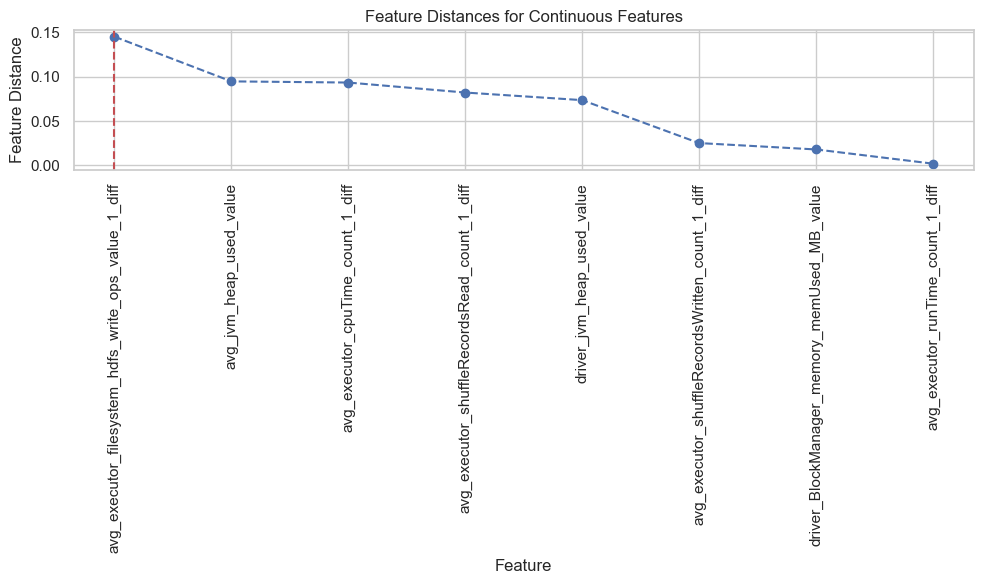

Significant features: ['avg_executor_filesystem_hdfs_write_ops_value_1_diff']


In [15]:
feature_distances = {}

for variable in continuous_features :
    TS = generate_TS(bursty_input1_df_filter, variable)
    H_Segmentation_plus = segmentation_entropy_plus(TS)
    Distance = entropy_feature_distance(class_entropy(TSA, TSR), segmentation_entropy_plus(TS))
    feature_distances[variable] = Distance

sorted_features = sorted(feature_distances.items(), key=lambda x: x[1], reverse=True)

def plot_feature_distances_with_elbow(sorted_features):
    variables, distances = zip(*sorted_features)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(variables, distances, marker='o', linestyle='--', color='b')
    plt.xlabel('Feature')
    plt.ylabel('Feature Distance')
    plt.title('Feature Distances for Continuous Features')
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Calculate differences between successive feature distances
    differences = [distances[i] - distances[i+1] for i in range(len(distances)-1)]

    # Threshold defined by the max dropout in distances
    threshold = max(differences)
    elbow_point = differences.index(threshold)

    # Add a red line to indicate the elbow point
    plt.axvline(x=variables[elbow_point], color='r', linestyle='--')

    # Show the plot
    plt.show()

    # Return significant features
    return list(variables[:elbow_point+1])

# Example usage
significant_features = plot_feature_distances_with_elbow(sorted_features)
print("Significant features:", significant_features)



# Step 2: false positive filtering

# Step 3: filtering by correlation clustering

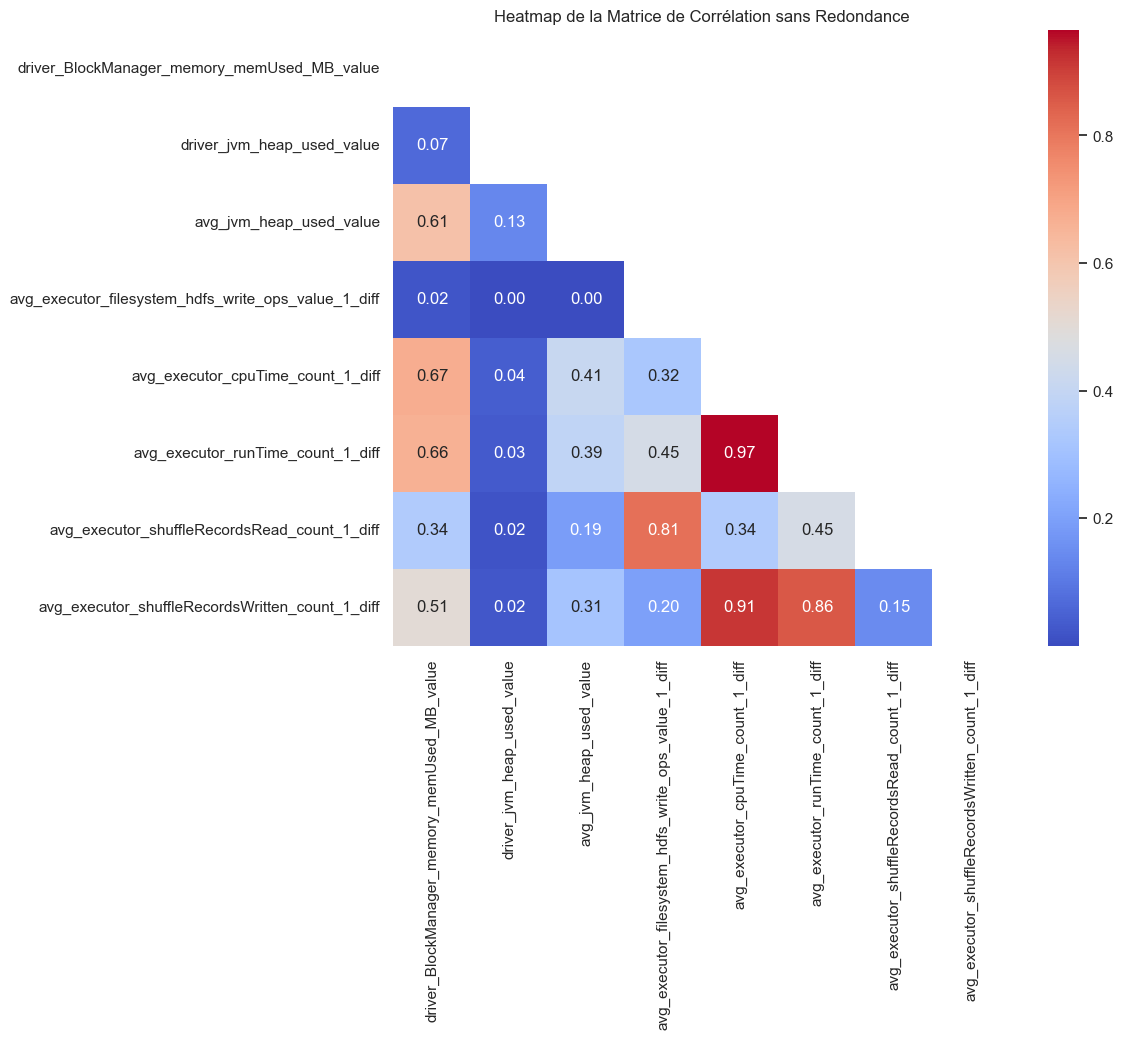

Caractéristiques représentatives sélectionnées :  ['avg_jvm_heap_used_value', 'avg_executor_filesystem_hdfs_write_ops_value_1_diff', 'driver_jvm_heap_used_value']
Cluster 0: driver_BlockManager_memory_memUsed_MB_value, avg_jvm_heap_used_value, avg_executor_cpuTime_count_1_diff, avg_executor_runTime_count_1_diff, avg_executor_shuffleRecordsWritten_count_1_diff
Representative feature: avg_jvm_heap_used_value

Cluster 1: avg_executor_filesystem_hdfs_write_ops_value_1_diff, avg_executor_shuffleRecordsRead_count_1_diff
Representative feature: avg_executor_filesystem_hdfs_write_ops_value_1_diff

Cluster 2: driver_jvm_heap_used_value
Representative feature: driver_jvm_heap_used_value



C:\Users\choho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [16]:
from sklearn.cluster import AgglomerativeClustering
#selected_features = significant_features
selected_features =  continuous_features
data = bursty_input1_df_final[selected_features]

# Calculer la matrice de corrélation en valeur absolue
corr_matrix = data.corr().abs()

# Créer une masque pour la partie supérieure du triangle (pour éliminer la redondance)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Création d'une Heatmap pour visualiser la matrice de corrélation sans redondance
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Heatmap de la Matrice de Corrélation sans Redondance')
plt.show()


# Créer un seuil pour identifier les corrélations fortes (par exemple 0.8)
threshold = 0.8

# Utiliser le clustering agglomératif pour regrouper les caractéristiques fortement corrélées
clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='complete', distance_threshold=threshold)
clustering.fit(1 - corr_matrix)  # Utiliser 1 - corr_matrix car le clustering agglomératif s'attend à des distances

# Identifier les représentants de chaque cluster
cluster_labels = clustering.labels_
unique_clusters = np.unique(cluster_labels)
representative_features = []

for cluster in unique_clusters:
    # Trouver les indices des caractéristiques dans chaque cluster
    indices = np.where(cluster_labels == cluster)[0]
    # Sélectionner la caractéristique avec la corrélation moyenne la plus basse dans le cluster
    avg_corr = corr_matrix.iloc[indices, indices].mean().idxmin()
    representative_features.append(avg_corr)

# Afficher les caractéristiques représentatives
print("Caractéristiques représentatives sélectionnées : ", representative_features)


# print chaque cluster avec les caractéristiques qui lui sont associées et son representant
for cluster in unique_clusters:
    indices = np.where(cluster_labels == cluster)[0]
    print(f"Cluster {cluster}:", ", ".join(data.columns[indices]))
    print(f"Representative feature: {representative_features[cluster]}\n")


# 5.4 Building final explanations
